# Surface Defect Segmentation
> An end-to-end workflow for image segmentation on the magnetic tile defect dataset using PyTorch, PyTorch Lightning, Segmentation models, and MLflow. This notebook trains state of the art image segmentation models on a highly imbalanced dataset, containing less than 1% of the target class.

- toc: true 
- badges: true
- comments: true
- categories: [pytorch, segmentationmodels, pytorchlightning, mlflow]

In this notebook we use the [segmentation models](https://github.com/qubvel/segmentation_models.pytorch) library built in PyTorch to train image segmentation models for the [Magnetic tile defect dataset](https://github.com/abin24/Magnetic-tile-defect-datasets.). This dataset is interesting because it is highly imbalanced, with less than 1% of pixels corresponding to the target class. Using the segmentation models library we can try several different loss functions, including binary cross entropy, focal losss, and Tversky loss to see their performance (see [here](https://arxiv.org/pdf/2006.14822.pdf) for recommended loss functions). However, it turns out that using binary cross entropy is sufficient to get good results.

Aditionally, following an [example](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb) in the segmentation models library, we'll use [PyTorch Lightning](https://www.pytorchlightning.ai/) to further simplify the training process in PyTorch and [MLflow](https://mlflow.org/) to log hyperparameters and metrics.

This code is built with the help of [Detection of Surface Defects in Magnetic Tile Images](https://github.com/MitraDP/Detection-of-Surface-Defects-in-Magnetic-Tile-Images) by Dr. Mitra P. Danesh.

In [ ]:
# Uncomment the following line if run in the jupyter tensorflow Docker image.
#!pip install torch torchvision 
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install pytorch-lightning
!pip install mlflow

In [47]:
import os
import math
import random

import torch
import numpy as np
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger

# set the random seeds for reproducibility
random.seed(42)
torch.manual_seed(0)
np.random.seed(0)

## Loading data

In [3]:
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
from glob import glob

First download the data locally.

In [4]:
%%capture
!wget -O data.zip https://github.com/abin24/Magnetic-tile-defect-datasets./archive/master.zip
!unzip data.zip
!mv Magnetic-tile-defect-datasets.-master data

In [5]:
classes =['Blowhole', 'Crack','Free'] # classes/labels
image_paths = []

for c in classes:
    # retreive image file paths recursively
    images_found = glob('data/MT_' + c + '/Imgs/*.jpg',recursive=True) 
    if c== 'Free': # undersample the free class.
        image_paths.extend( images_found[:80] )
    else:
        image_paths.extend( images_found )        
    
random.shuffle(image_paths)

In [6]:
len(image_paths)

252

### Dataset

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data. Also see the [binary segmentation intro](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb) in the segmentation models library for more details on designing the Dataset class. For more sophisticated data augmentations, see the [albumentations](https://albumentations.ai/) library and specifically [this](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb) notebook from segmentation models.

In [7]:
import torchvision.transforms.functional as TF
import random

class SurfaceDefectDetectionDataset(Dataset):
    def __init__(self, image_path_list, use_transform=False):
        super().__init__()
        self.image_path_list = image_path_list
        self.use_transform = use_transform
        
    def transform(self, image, target):
        if random.random() < 0.5:
            image = TF.hflip(image)
            target = TF.hflip(target)
    
        if random.random() < 0.5:
            image = TF.vflip(image)
            target = TF.vflip(target)
    
        angle = random.choice([0, -90, 90, 180])
        image, target = TF.rotate(image, angle), TF.rotate(target, angle)
    
        return image, target
        
    def __len__(self):
        return len(self.image_path_list)
    
    def __getitem__(self, idx):
        # Open the image file which is in jpg  
        image = Image.open(self.image_path_list[idx])
        # The mask is in png. 
        # Use the image path, and change its extension to png to get the mask's path.
        mask = Image.open(os.path.splitext(self.image_path_list[idx])[0]+'.png') 
        
        # resize the images.
        image, mask = TF.resize(image, (320,320)), TF.resize(mask, (320,320))
        
        # Perform augmentation if required.
        if self.use_transform:
            image, mask = self.transform(image, mask)
        
        # Transform the image and mask PILs to torch tensors. 
        image, mask = TF.to_tensor(image), TF.to_tensor(mask)
        
        # Threshold mask, threshold limit is 0.5
        mask = (mask >= 0.5)*(1.0)
        
        #return the image and mask pair tensors
        return image, mask

In [8]:
split_len = int(0.8*len(image_paths))
train_dataset = SurfaceDefectDetectionDataset(image_paths[:split_len], use_transform = True)
test_dataset = SurfaceDefectDetectionDataset(image_paths[split_len:], use_transform = False)

We'll randomly split the train and validation set, but fix the random seed to fix these datasets.

In [9]:
train_dataset, val_dataset = random_split(train_dataset, [int(split_len*0.9), split_len - int(split_len*0.9)], generator=torch.Generator().manual_seed(1))

In [10]:
print('Length of train dataset: ', len(train_dataset))
print('Length of validation dataset: ', len(val_dataset))
print('Length of test dataset: ', len(test_dataset))

Length of train dataset:  180
Length of validation dataset:  21
Length of test dataset:  51


#### Let's take a look at the dataset

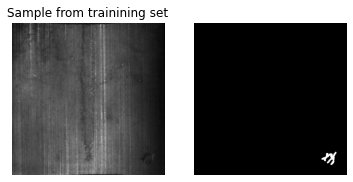

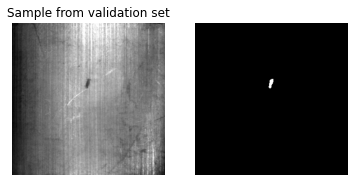

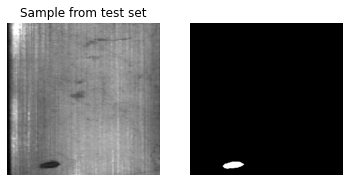

In [11]:
import matplotlib.pyplot as plt
import random

sample_img, sample_msk = train_dataset[random.choice(range(len(train_dataset)))]
plt.subplot(1,2,1)
plt.title("Sample from trainining set")
plt.axis("off")
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(sample_msk.squeeze(), cmap='gray')
plt.show()

sample_img, sample_msk = val_dataset[random.choice(range(len(val_dataset)))]
plt.subplot(1,2,1)
plt.title("Sample from validation set")
plt.axis("off")
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(sample_msk.squeeze(), cmap='gray')
plt.show()

sample_img, sample_msk = test_dataset[random.choice(range(len(test_dataset)))]
plt.subplot(1,2,1)
plt.title("Sample from test set")
plt.axis("off")
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(sample_msk.squeeze(), cmap='gray')
plt.show()

Take a look at more samples from the train set.

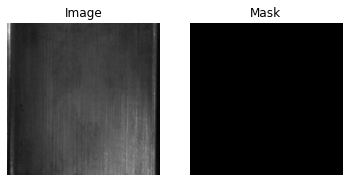

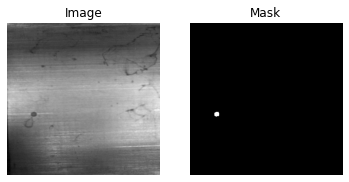

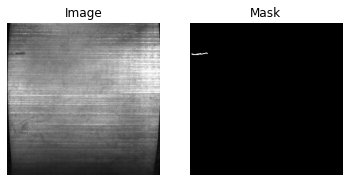

In [12]:
for i in range(3):
    sample_img, sample_msk = train_dataset[random.choice(range(len(train_dataset)))]
    plt.subplot(1,2,1)
    plt.title("Image")
    plt.axis("off")
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.subplot(1,2,2)
    plt.title("Mask")
    plt.axis("off")
    plt.imshow(sample_msk.squeeze(), cmap='gray')
    plt.show()

Find the weight of positive and negative pixels.

The number of positive pixels is less than 1% of the total, showing that
the dataset is highly imbalanced.

In [13]:
positive_weight = 0
negative_weight = 0
total_pixels = 0
img_shape = train_dataset[0][0].shape
for _, target in train_dataset:
    positive_weight += (target >= 0.5).sum().item()
    negative_weight += (target < 0.5).sum().item()
    total_pixels += (img_shape[1] * img_shape[2])
positive_weight /= total_pixels
negative_weight /= total_pixels
print('positive weight = ',positive_weight, '\tnegative weight = ', negative_weight)

positive weight =  0.002119411892361111 	negative weight =  0.9978805881076389


## Create model and train

In [14]:
from itertools import islice

def show_predictions_from_batch(model, dataloader, batch_num=0, limit = None):
    """
        Method to visualize model predictions from batch batch_num.
        
        Show a maximum of limit images.
    """
    batch = next(islice(iter(dataloader), batch_num, None), None) # Selects the nth item from dataloader, returning None if not possible.
    images, masks = batch

    with torch.no_grad():
        model.eval()

        logits = model(images)

    pr_masks = logits.sigmoid()
    pr_masks = (pr_masks >= 0.5)*1

    for i, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
        if limit and i == limit:
            break
        fig = plt.figure(figsize=(15,4))

        ax = fig.add_subplot(1,3,1)
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title("Image")
        ax.axis("off")

        ax = fig.add_subplot(1,3,2)
        ax.imshow(gt_mask.squeeze(), cmap='gray')
        ax.set_title("Ground truth")
        ax.axis("off")

        ax = fig.add_subplot(1,3,3)
        ax.imshow(pr_mask.squeeze(), cmap='gray')
        ax.set_title("Predicted mask")
        ax.axis("off")

We'll create a PyTorch Lightning module to help streamline the training process. In the class initalization, it uses the segmentation models library, via the call to  `smp.create_model`, to build a PyTorch model which operates on one channel images for binary segmentation. Many state of the art models are possible with the segmentation models library. However, we'll typically use the Unet with resnet34 backbone.

We use the `SoftBCEWithLogitsLoss` to train the model, but other losses recommended [here](https://arxiv.org/pdf/2006.14822.pdf), can easily be used as well.

We'll also use the segmentation models library to monitor the *intersection over union* metric. Due to the highly imbalanced nature of this dataset, this will give us a much better indicator of model quality than the accuracy.

In [15]:
class SurfaceDefectModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, loss = "SoftBCEWithLogitsLoss" , **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, encoder_weights = None, in_channels=1, classes=1, **kwargs
        )

        self.arch = arch
        self.encoder_name = encoder_name
        
        self.loss_name = loss
        if loss == "DiceLoss":
            self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        elif loss == "TverskyLoss":
            self.loss_fn = smp.losses.TverskyLoss(smp.losses.BINARY_MODE, from_logits=True, alpha=0.3,beta=0.7)
        elif loss == "FocalLoss":
            self.loss_fn = smp.losses.FocalLoss(smp.losses.BINARY_MODE)              
        else:
            self.loss_fn = smp.losses.SoftBCEWithLogitsLoss()
            
        self.printed_run_id = None
        self.run_id = None
        
    def forward(self, image):
        return self.model(image)

    def shared_step(self, batch, stage):
        
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        
        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        accuracy = smp.metrics.accuracy(tp, fp, fn, tn)
        
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_accuracy": accuracy,
            f"{stage}_loss": torch.tensor([x["loss"].item() for x in outputs]).mean()
        }
        
        # Log the metrics
        #for key, val in metrics.items():
        #    self.logger.experiment.log_metric(self.logger.run_id ,key,  val.mean().item(), step=self.current_epoch)
        self.logger.log_metrics({key: val.mean().item() for key, val in metrics.items() }, step=self.current_epoch)
        
        # only record the loss in mlflow
        del metrics[f"{stage}_loss"]
        if not self.printed_run_id and hasattr(self.logger, "run_id"):
            print('Run id: ', self.logger.run_id )
            self.printed_run_id = True
            
        # This will be available in tensorboard.
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)
    
    def on_fit_end(self):
        # Log hyperparameters to mlflow.
        self.logger.log_hyperparams({ "arch": self.arch, "encoder_name": self.encoder_name, "loss": self.loss_name })
        if hasattr(self.logger, "run_id"):
          self.run_id = self.logger.run_id

Note that we added the extra hook `on_fit_end` to save hyperparameters to MLflow. More hooks are available at the official documentation [lightning hooks](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#lightning-hooks).

In [44]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

In [49]:
model = SurfaceDefectModel("Unet", "resnet34")

Sanity check the model by showing its predictions. 

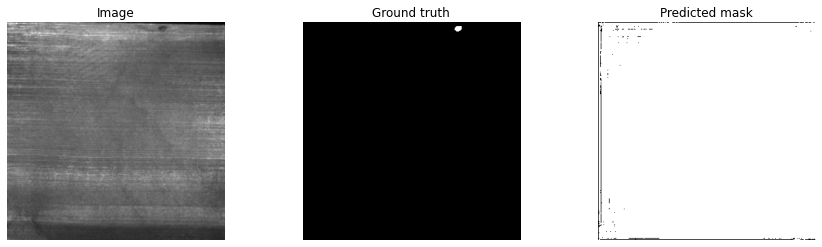

In [50]:
show_predictions_from_batch(model, train_loader, batch_num=0, limit=1)

We'll use the `ModelCheckpoint` callback from PyTorch lightning to save the best model, as measured by the intersection over union metric.

In [53]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pathlib import Path

checkpoint_callback = ModelCheckpoint(
    monitor="valid_dataset_iou",
    dirpath="./models",
    filename= f"surface_defect_{model.arch}_{model.encoder_name}_{model.loss_name}",
    save_top_k=3,
    mode="max",
)

# Add the model directory if it it doesn't exist
Path("./models").mkdir(exist_ok=True)

Now with the help of PyTorch lightning, we can train and log to MLflow, with a few lines of code.

In [54]:
mlf_logger = MLFlowLogger(experiment_name="lightning_logs")
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=200,
    log_every_n_steps=math.ceil(len(train_dataset)/batch_size),
    callbacks=[checkpoint_callback],
    logger=mlf_logger,
    # For debugging purposes, uncomment the line below.
    #fast_dev_run=True 
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | Unet                  | 24.4 M
1 | loss_fn | SoftBCEWithLogitsLoss | 0     
--------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.720    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Load the best model to analyze its performance.

In [ ]:
model.load_from_checkpoint(f"models/surface_defect_{model.arch}_{model.encoder_name}_{model.loss_name}.ckpt", arch = model.arch, encoder_name= model.encoder_name, loss = model.loss_fn.__class__.__name__)

In [35]:
# run validation dataset
trainer.validate(model, dataloaders=valid_loader, verbose=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

[{'valid_accuracy': 0.9992690682411194,
  'valid_dataset_iou': 0.6964665055274963,
  'valid_per_image_iou': 0.8290141820907593}]

Visualize the model performance on the validation set.

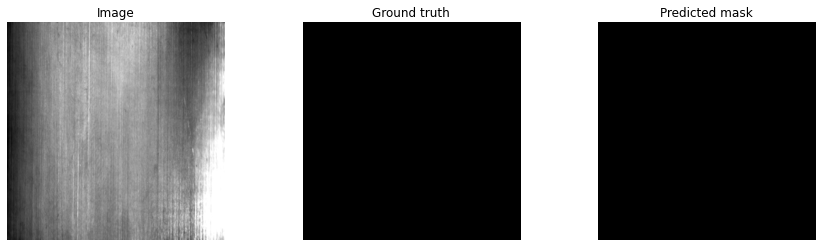

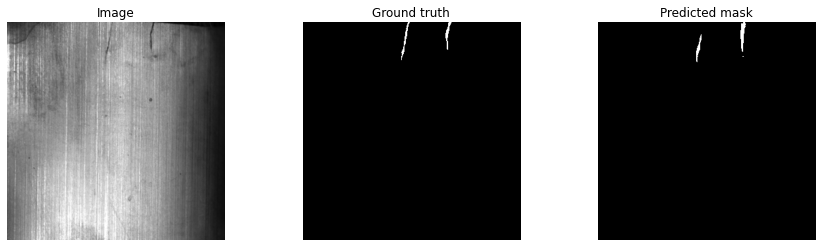

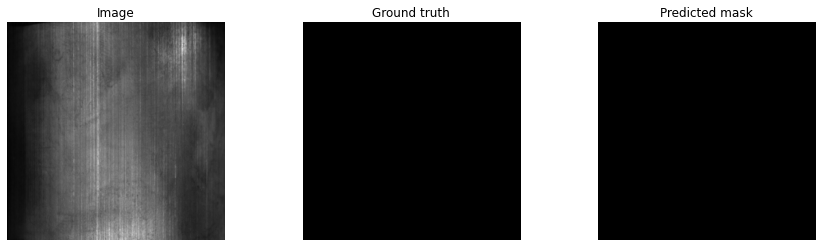

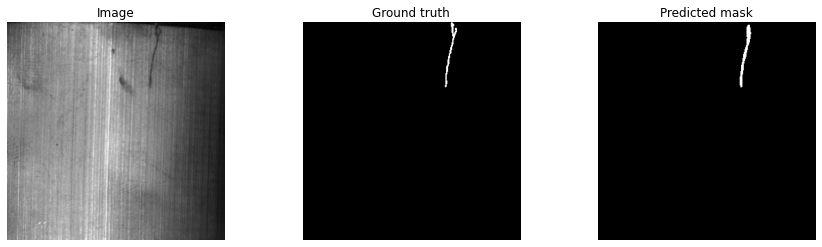

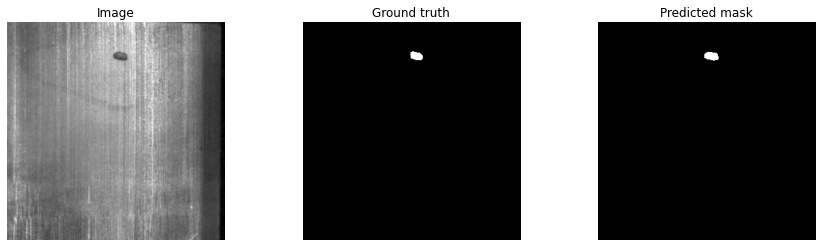

In [37]:
for i in range(min(len(valid_loader), 5)):
    show_predictions_from_batch(model, valid_loader, batch_num=i)

## Analyze best saved model on the Test set

In [38]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [39]:
# run test dataset
trainer.test(model, dataloaders=test_loader, verbose=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_accuracy': 0.9993646740913391,
  'test_dataset_iou': 0.672004759311676,
  'test_per_image_iou': 0.7291520237922668}]

Finally, visualize the model performance on the test set.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


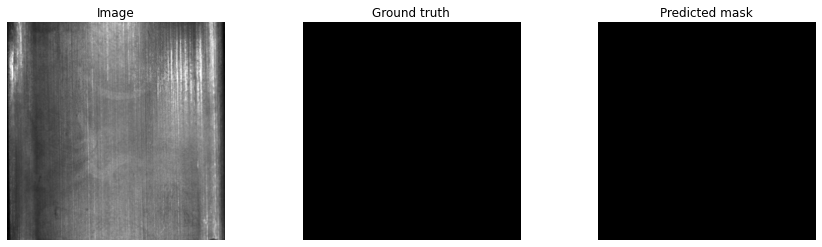

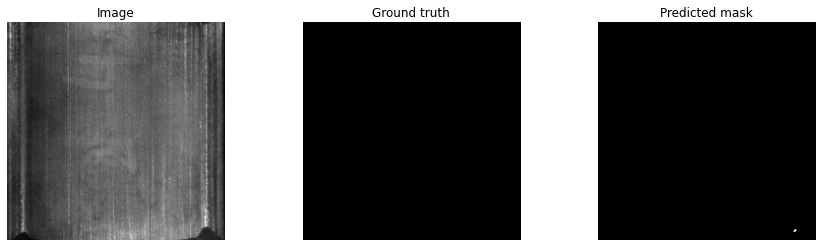

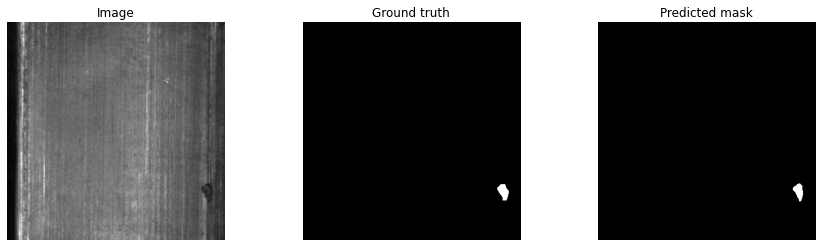

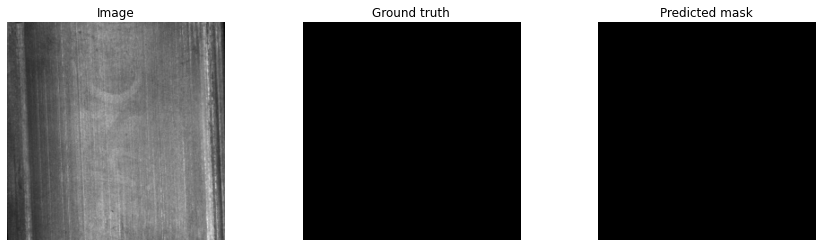

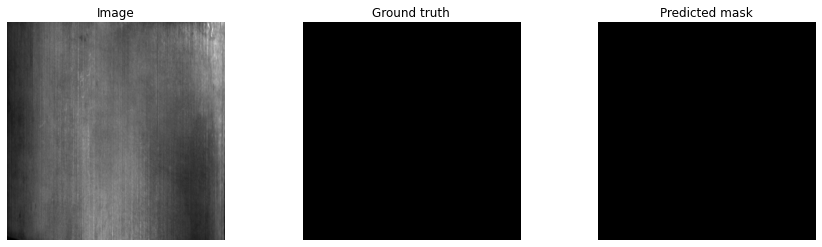

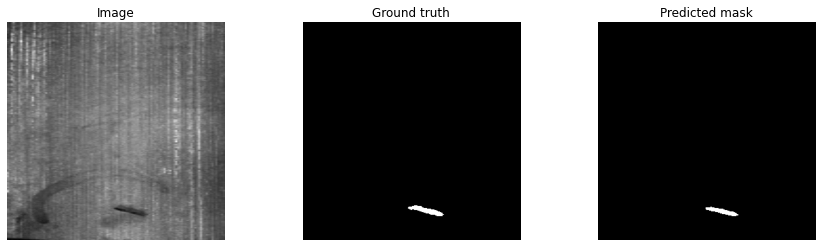

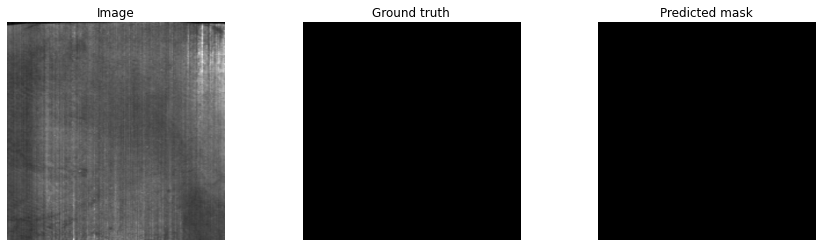

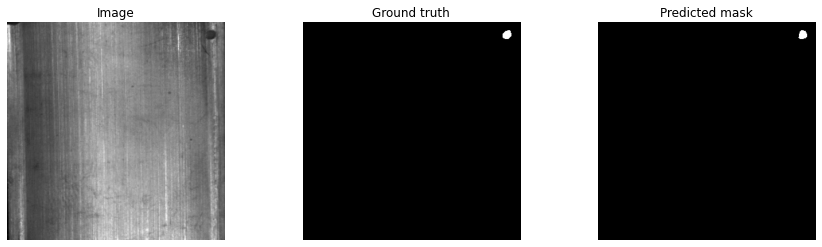

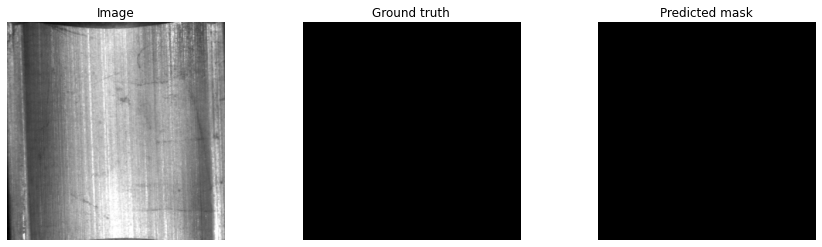

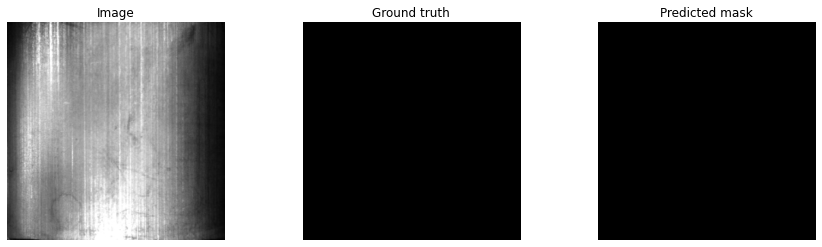

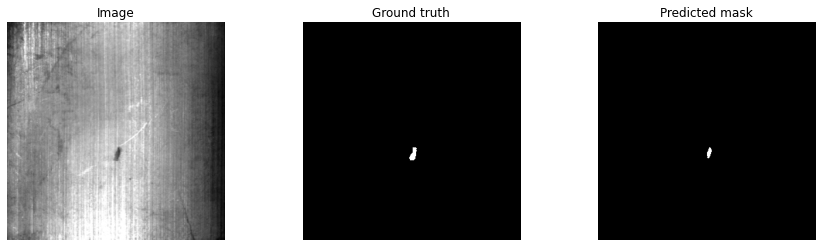

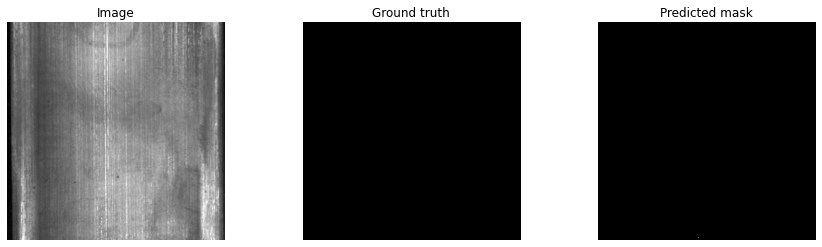

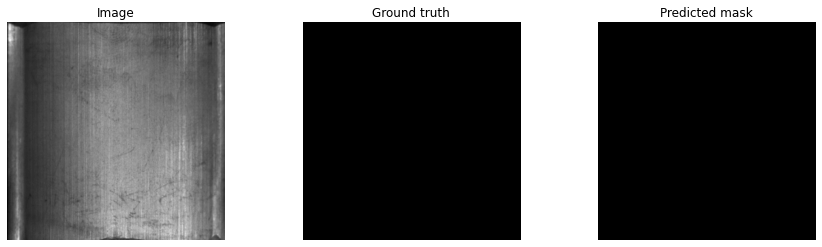

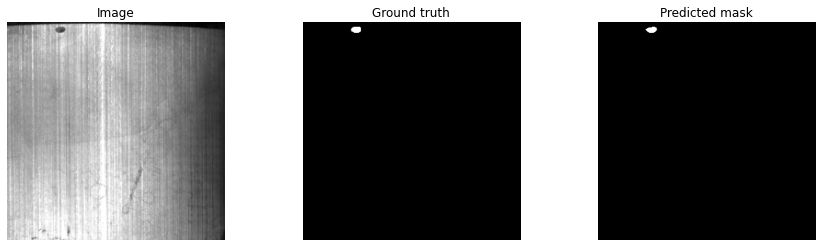

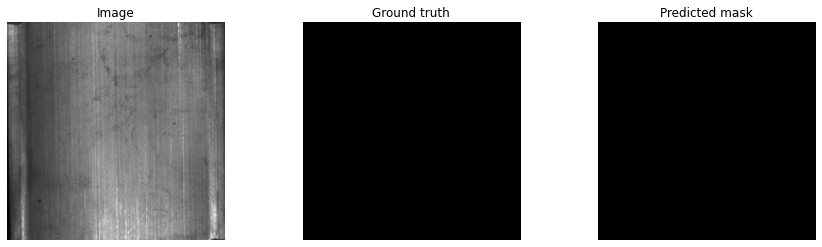

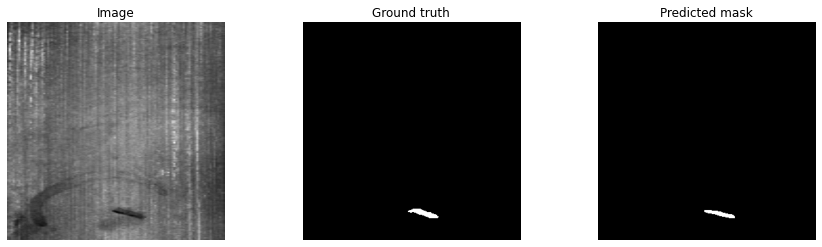

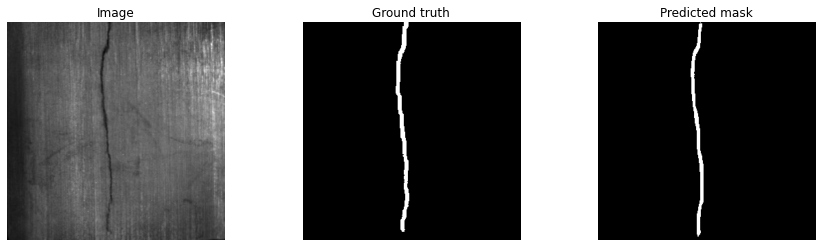

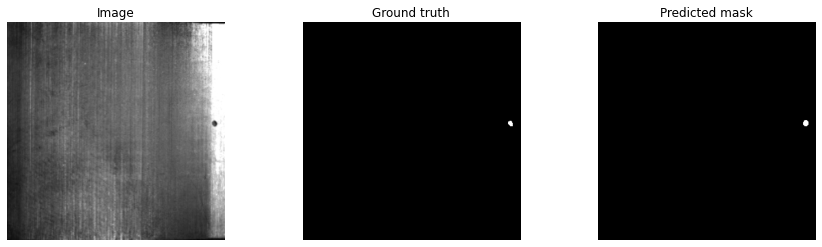

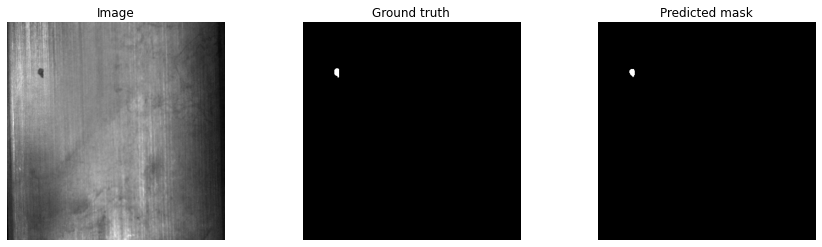

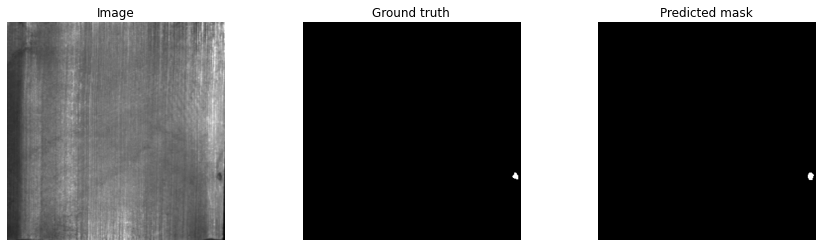

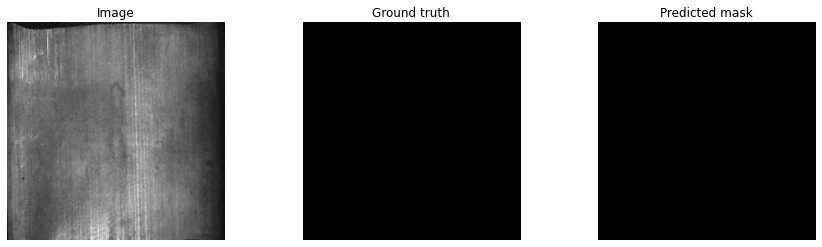

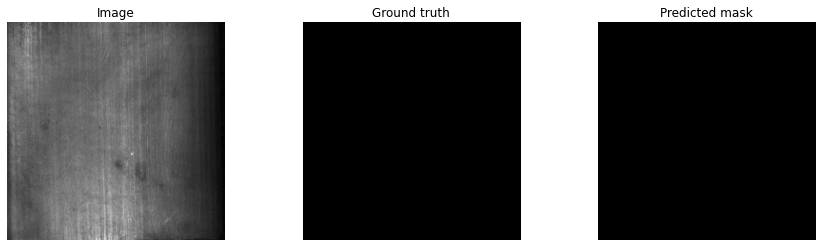

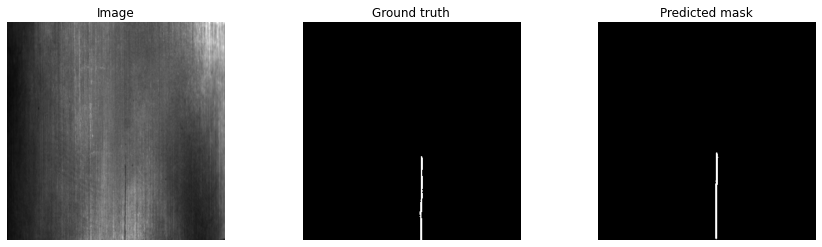

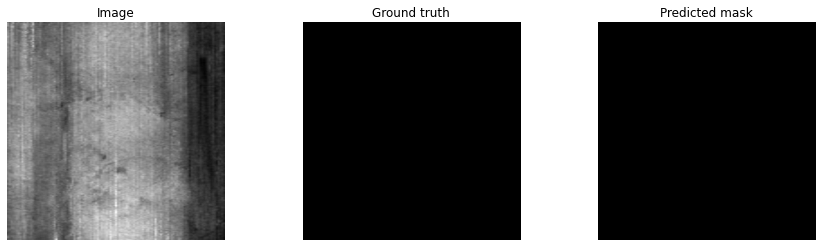

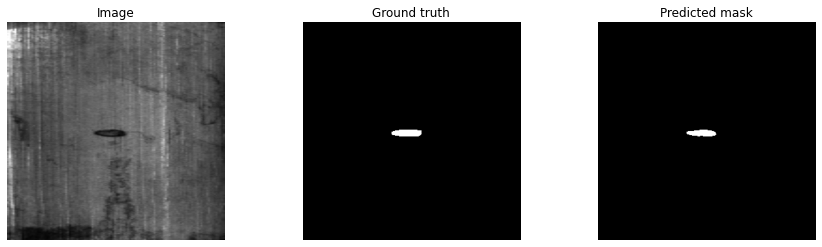

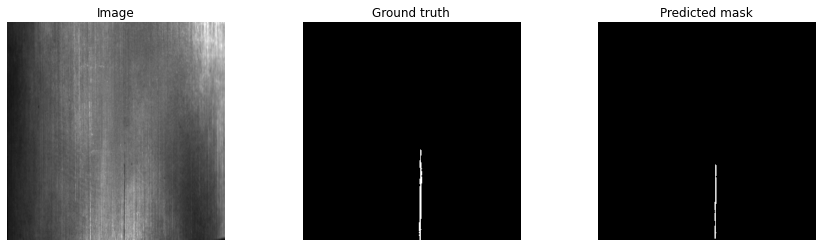

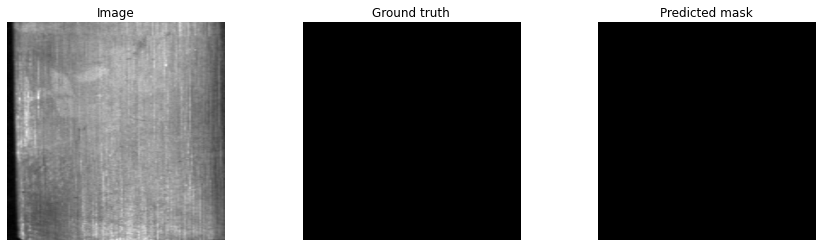

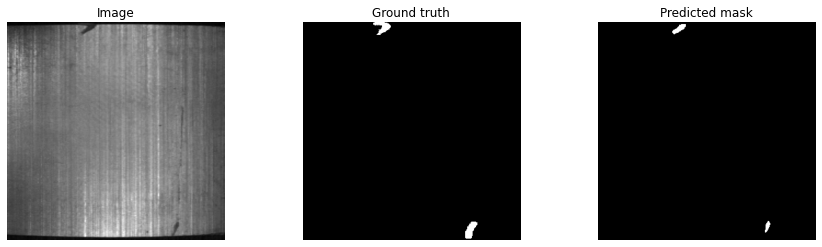

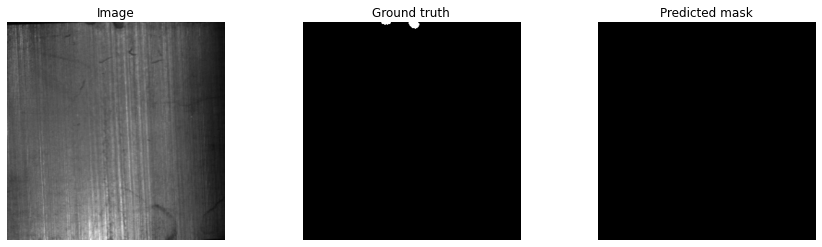

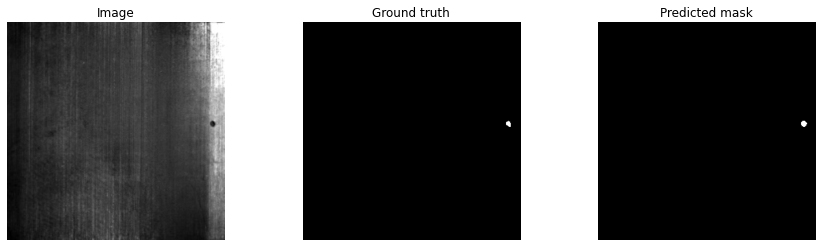

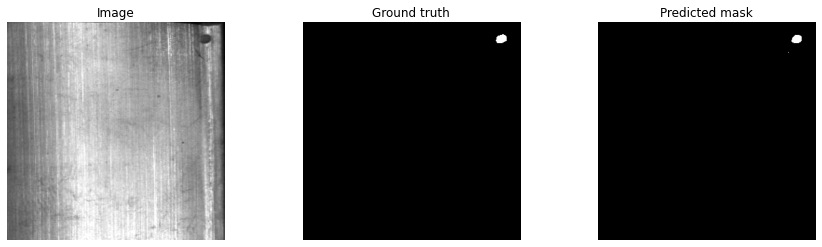

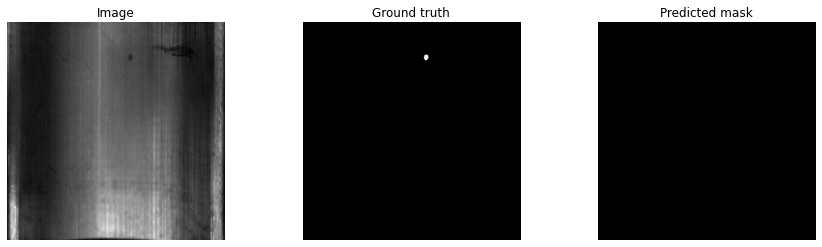

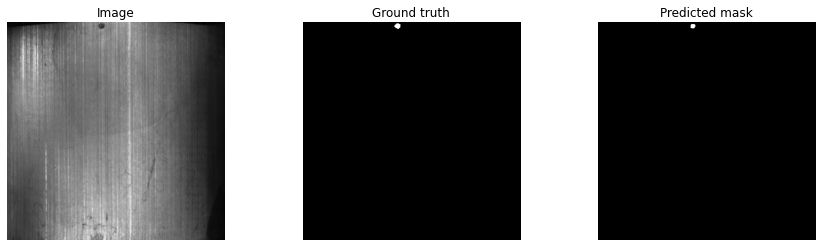

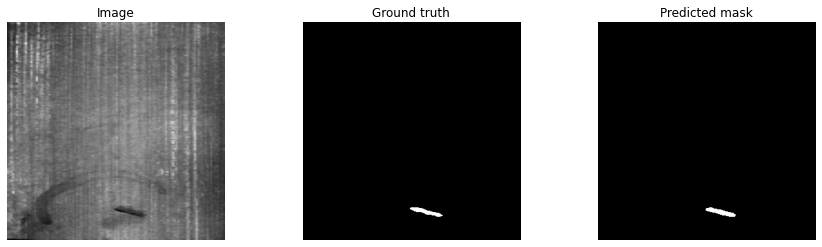

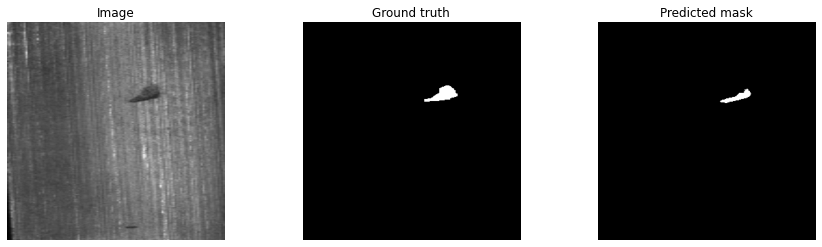

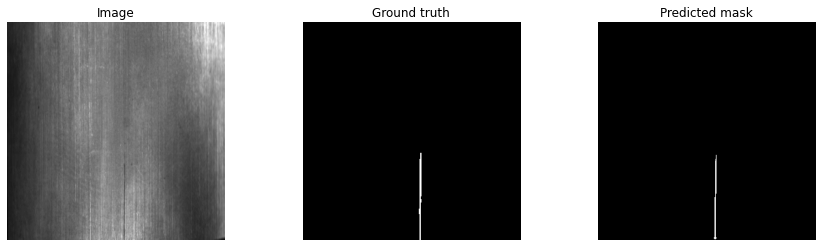

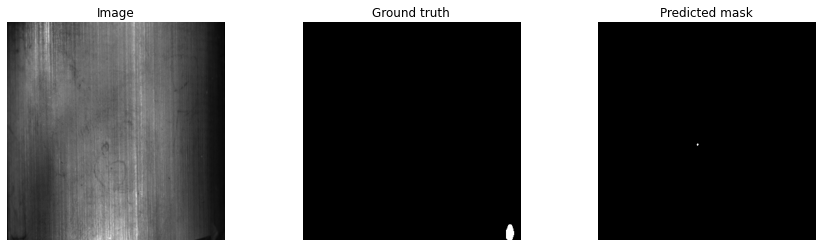

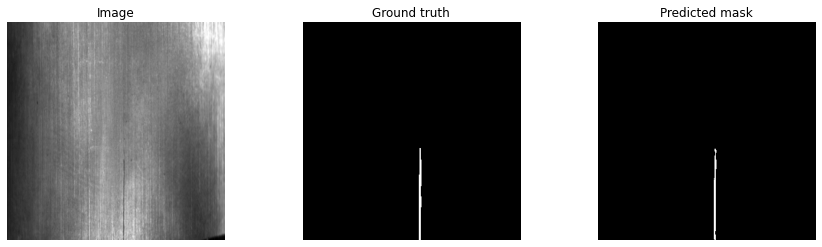

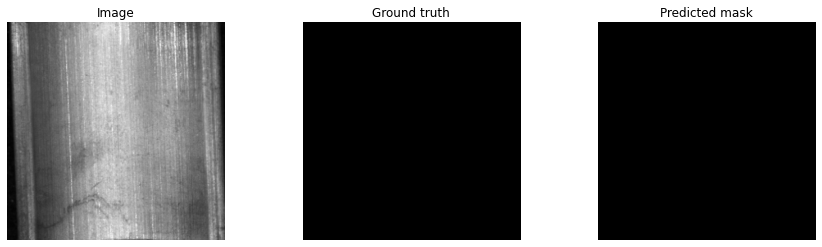

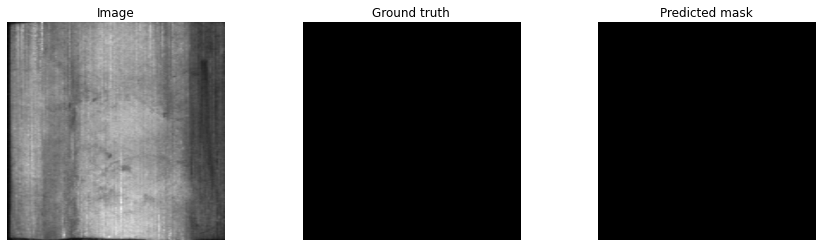

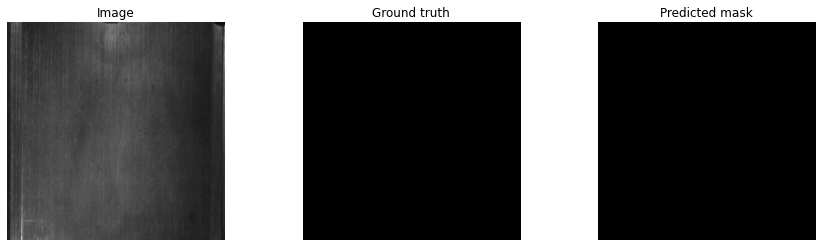

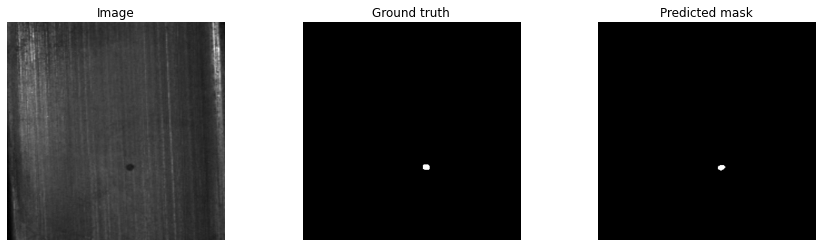

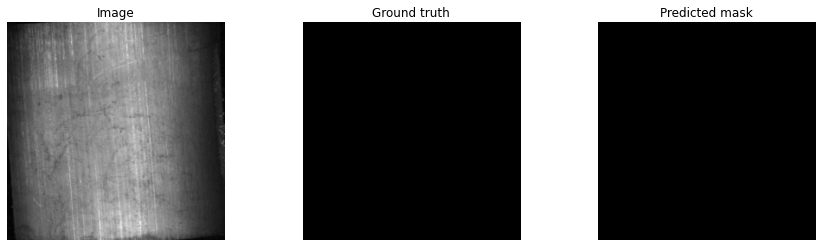

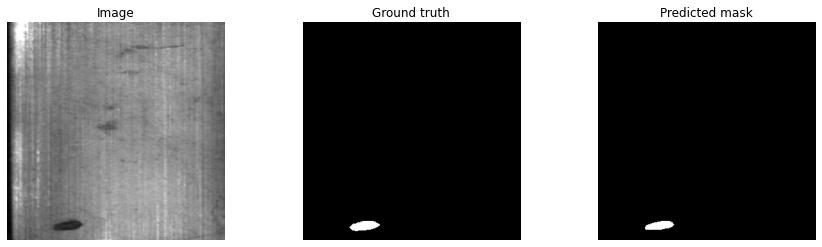

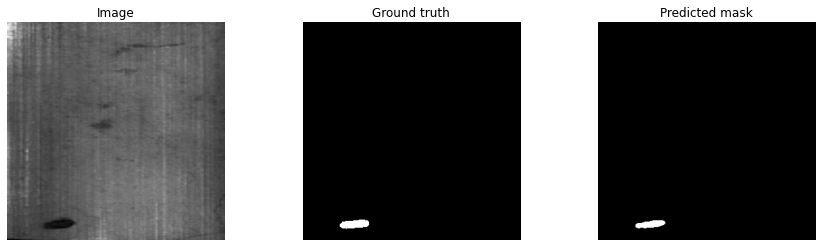

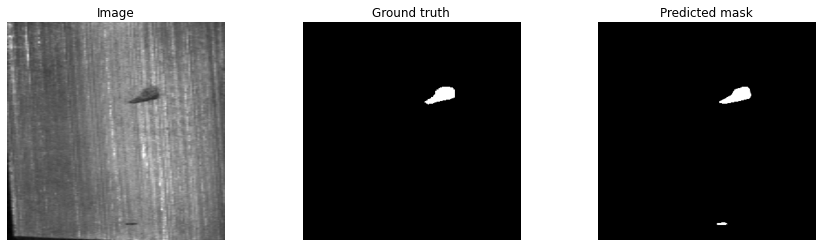

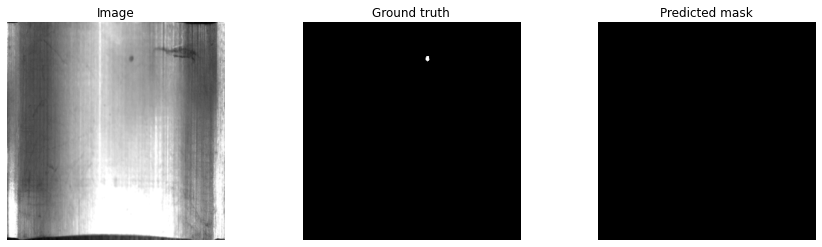

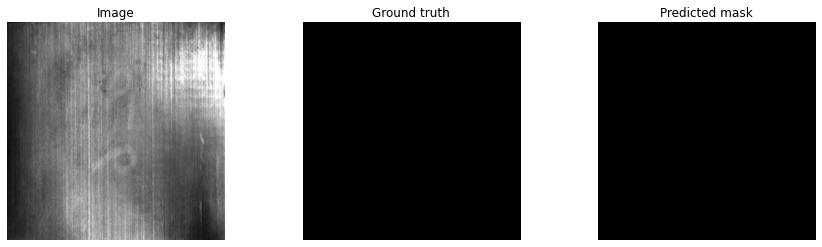

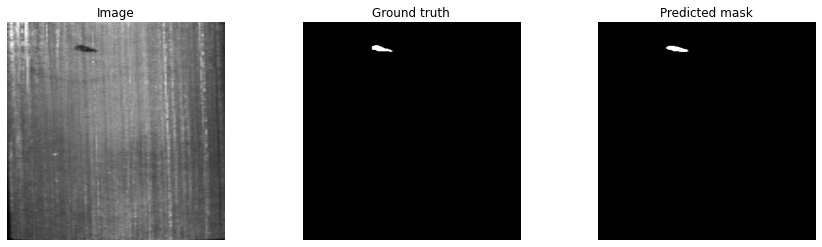

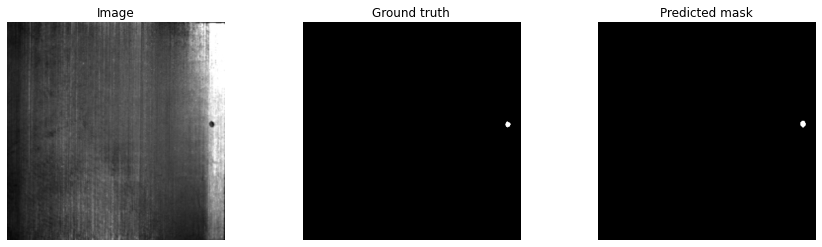

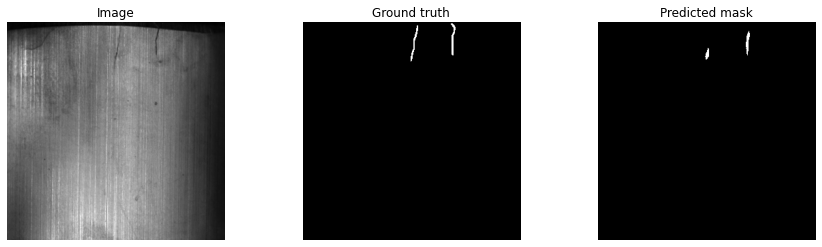

In [40]:
for i in range(min(len(test_loader), 10)):
    show_predictions_from_batch(model, test_loader, batch_num=i)